In [1]:
import pandas as pd
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import ast #ast.literal_eval() 함수는 문자열을 분석하여 실제 파이썬의 List나 Dictionary 객체로 변환

In [2]:
df_cleanmatch = pd.read_csv("cleanmatch_c.csv") #클린 매치.csv
df_cham = pd.read_csv("TFT_Champion_CurrentVersion.csv") #TFT_Champion_CurrentVersion.csv
df_item = pd.read_csv("TFT_Item_CurrentVersion.csv") #TFT_Item_CurrentVersion.csv

In [10]:
'''
# ----- 목표 ------ #
- 유저들이 많이 사용하는 챔피언은 어떤게 있는지 top 10
- 해당 챔피언을 사용하는 유저들의 평균 등수

# ----- 메타 데이터 매핑 ------ #

1. champion 컬럼 문자열 > 딕셔너리로 변환

2. total_cost 컬럼(파생 변수) : 한 플레이어가 최종적으로 필드에 배치한 모든 챔피언의 'cost'를 단순히 합산한 값 (❌챔피언을 사는 데 들어간 총 골드❌)
iqr 기반 이상치 제거 및 분석을 위해 생성 / 플레이어가 사용한 총 코스트가 일반적인 범위를 벗어나는 경우 (ex: 버그성으로 코스트가 너무 높게 기록된 경우)를 제거
total cost = (2코스트*3챔피언) + (4코스트*2챔피언)...

'''
df_cleanmatch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399651 entries, 0 to 399650
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   gameId          399651 non-null  object 
 1   gameDuration    399651 non-null  float64
 2   level           399651 non-null  int64  
 3   lastRound       399651 non-null  int64  
 4   Ranked          399651 non-null  int64  
 5   ingameDuration  399651 non-null  float64
 6   combination     399651 non-null  object 
 7   champion        399651 non-null  object 
 8   tier            399651 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 27.4+ MB


In [9]:
%%time

# --- 챔피언 - 코스트 메타데이터 매핑 ---- #

# 챔피언 이름을 소문자 없이, 공백 없이 적용 시켜주고 그 이름을 기준으로 데이터프레임의 챔피언 이름과 메타데이터의 챔피언 이름이 일치하지 않는 목록을 추출

df_champion = df_cham.copy()


# 1. 코스트 맵에 사용될 챔피언 이름 목록 (모두 소문자, 공백 없음)을 만들기
champion_name_set = set(df_champion['name'].str.strip().str.lower())

# df_main을 현재 사용 중인 데이터프레임으로 설정
df_main = df_cleanmatch.copy() 


# 2. 'champion' 문자열 컬럼을 실제 List/Dictionary 객체로 변환
# safe_literal_eval 함수가 문자열 데이터를 객체로 안전하게 변환, 깨진 데이터는 빈 리스트로 처리

def safe_literal_eval(x):
    if pd.isna(x):                       #입력 값 x가 결측치라면, 함수는 즉시 빈 리스트 []를 반환하고 종료
        return []
    try:
        return ast.literal_eval(x)       #문자열 x를 객체로 변환
    except:
        return []                        #파싱 오류 발생 시 빈 리스트 반환

# 'champion_list'컬럼을 만들고 그 안에 내용을 채워 넣어줌
df_main['champion_list'] = df_main['champion'].apply(safe_literal_eval)
#df_main 데이터프레임의 기존 'champion' 컬럼에 정의한 safe_literal_eval 함수를 모든 행에 걸쳐 적용


# 3. 모든 챔피언 이름을 추출하고 정규화

# "중복 없이" 오리지널 이름만 가져와서 정규화 시키기 위해 set()
all_champs_extracted = set()

# 모든 행을 순회하며 챔피언 이름을 추출하고 정규화
for champion_list in df_main['champion_list']:
    for champ_data in champion_list:
        if isinstance(champ_data, dict):            #champ_data가 딕셔너리(dict) 타입일 때만 다음 로직을 실행 | 이상한 값이 섞여 있을 경우 대비
            raw_name = champ_data.get('champion')   #.get()을 사용하면 해당 키가 없더라도 오류 대신 None을 반환
            if raw_name: #유효한 문자열일 경우 이름 정규화: 공백 제거 및 소문자 변환
                clean_name = raw_name.strip().lower()
                all_champs_extracted.add(clean_name)


# 4. 불일치 항목 필터링
# 데이터에는 있지만 메타데이터(champion_name_set)에는 없는 챔피언을 찾기
unmatched_champions = sorted(list(all_champs_extracted - champion_name_set))

## 5. 결과 출력
if unmatched_champions:
    print("\n⚠️ 메타데이터와 일치하지 않는 챔피언 목록:")
    print(unmatched_champions)
else:
    print("\n✅ 모든 챔피언 이름이 메타데이터와 성공적으로 일치합니다.")


✅ 모든 챔피언 이름이 메타데이터와 성공적으로 일치합니다.
CPU times: total: 1min 28s
Wall time: 1min 29s


In [13]:
# 1. 챔피언 코스트 메타데이터 파일 로드
# TFT_Champion_CurrentVersion.csv 파일을 다시 로드하여 df_champion 변수에 저장합니다.
try:
    df_champion = pd.read_csv('TFT_Champion_CurrentVersion.csv') 
except FileNotFoundError:
    print("오류: TFT_Champion_CurrentVersion.csv 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    # 파일이 없으면 맵을 만들 수 없습니다.
    # return

# 2. 코스트 맵 생성 (이전에 사용했던 코드 그대로 사용 가능)
# 챔피언 이름('name')을 인덱스(Key)로, 코스트('cost')를 값(Value)으로 하는 딕셔너리(Map) 생성
champion_cost_map = df_champion.set_index('name')['cost'].to_dict()

print("✅ champion_cost_map 로드 및 생성 완료.")


✅ champion_cost_map 로드 및 생성 완료.


In [14]:
%%time
# "토탈 코스트 컬럼 만들기"


def calculate_total_cost_fixed(champion_data_dict, cost_map):
    total_cost = 0
    if not isinstance(champion_data_dict, dict):
        # 딕셔너리가 아닌 경우 계산 중지 (안전 장치)
        return 0
    
    # 딕셔너리의 '값'들만 순회합니다. (즉, {'items': [7], 'star': 1} 등의 정보)
    # 챔피언 이름은 이 딕셔너리의 키(Key)에 해당
    
    # 챔피언 이름 (Key)과 상세 정보 (Value)를 동시에 순회
    for raw_name, champ_data in champion_data_dict.items():
        
        if raw_name:
            # 챔피언 이름 정규화 (Key가 챔피언 이름입니다.)
            clean_name = raw_name.strip().lower() 
            
            # 정규화된 이름으로 코스트 조회
            total_cost += cost_map.get(clean_name, 0)
        
    return total_cost

# total_cost 컬럼 재생성
# df_main['champion_list'] 컬럼을 입력으로 사용합니다.
df_main['total_cost'] = df_main['champion_list'].apply(
    lambda x: calculate_total_cost_fixed(x, champion_cost_map)
)

print("'total_cost' 컬럼 생성이 완료되었습니다.")
print(df_main[['total_cost']].head())

'total_cost' 컬럼 생성이 완료되었습니다.
   total_cost
0          13
1          20
2          12
3          15
4          17
CPU times: total: 1.23 s
Wall time: 1.33 s


In [36]:
# "토탈코스트 컬럼 제대로 넣었는지 확인"

# df_main의 첫 번째 행 (Index 0) 추출
sample_row = df_main.iloc[0]

# 해당 행의 champion_list (객체)와 total_cost 확인
cost_calculated = sample_row['total_cost']
champion_data = sample_row['champion_list']

print(f"계산된 Total Cost: {cost_calculated}")
print(f"챔피언 데이터: {champion_data}")

계산된 Total Cost: 13
챔피언 데이터: {'Ziggs': {'items': [7], 'star': 1}, 'Ashe': {'items': [9], 'star': 1}, 'ChoGath': {'items': [6], 'star': 1}, 'Ekko': {'items': [1], 'star': 1}}


Matplotlib 폰트 설정 완료: KoreanTITGD2R


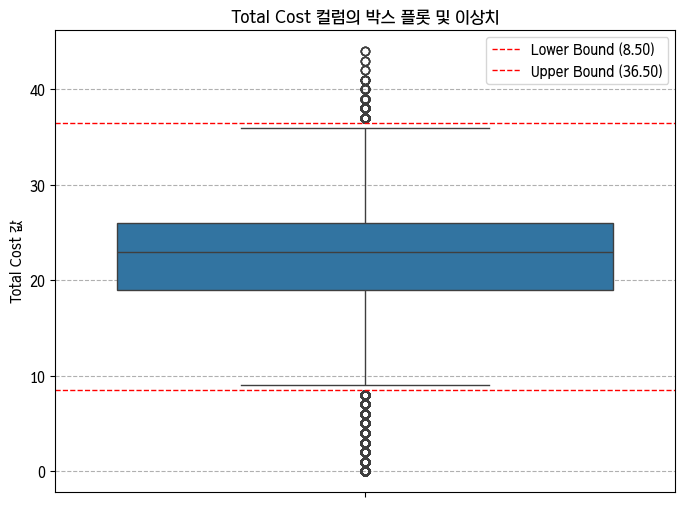


[Total Cost] 컬럼의 기술 통계량:
count    399651.000000
mean         22.409625
std           5.201618
min           0.000000
25%          19.000000
50%          23.000000
75%          26.000000
max          44.000000
Name: total_cost, dtype: float64


In [15]:
# --- 토탈코스트 이상치 시각화 그래프 ---

# df_main (total_cost 컬럼이 포함된 데이터프레임)을 사용

# 1. 폰트 설정 (한글 깨짐 방지)
font_name = fm.FontProperties(fname="C:/Windows/Fonts/a타이틀고딕2.ttf").get_name() 

# Matplotlib의 폰트 설정
plt.rc('font', family=font_name)

# 마이너스 부호 깨짐 방지 설정
# (시각화 시 축에 마이너스 기호가 나타날 경우 깨지는 현상 방지)
plt.rcParams['axes.unicode_minus'] = False 
print(f"Matplotlib 폰트 설정 완료: {font_name}")


# 2. 박스 플롯 시각화
plt.figure(figsize=(8, 6))

# total_cost 컬럼의 박스 플롯을 그리기
# 이상치는 점(Outliers)으로 표시
sns.boxplot(y=df_main['total_cost'])

# 3. 플롯 제목 및 라벨 설정
plt.title('Total Cost 컬럼의 박스 플롯 및 이상치')
plt.ylabel('Total Cost 값')
plt.grid(axis='y', linestyle='--')

# 4. IQR 경계선 시각화 (선택 사항: 더욱 명확한 시각화를 위해)
Q1 = df_main['total_cost'].quantile(0.25)
Q3 = df_main['total_cost'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# IQR 경계선 (제거 대상)을 빨간색 점선으로 표시
plt.axhline(lower_bound, color='r', linestyle='--', linewidth=1, label=f'Lower Bound ({lower_bound:.2f})')
plt.axhline(upper_bound, color='r', linestyle='--', linewidth=1, label=f'Upper Bound ({upper_bound:.2f})')
plt.legend()


plt.show()

# 5. 기술 통계량 출력 (참고용)
print("\n[Total Cost] 컬럼의 기술 통계량:")
print(df_main['total_cost'].describe())

In [17]:
%%time
'''
토탈코스트 이상치 제거 상한 이상치
# 상한 이상치 (매우 높은 코스트): 36.50 (또는 29.00)을 넘어가는 높은 코스트는 버그성 코스트이거나, 
9레벨 이상의 극단적인 레벨 업을 통해 5코스트 챔피언을 대량 배치한 게임일 수 있습니다. 분석의 일반성을 위해 제거하는 것이 좋습니다.

# 하한 이상치 (매우 낮은 코스트): 8.50 (또는 13.00) 미만의 낮은 코스트는 플레이어가 초반에 너무 빨리 나가서 보드가 비어있거나, 
AFK(잠수) 등으로 인해 챔피언을 배치하지 않은 기록일 가능성이 높습니다. 이러한 기록은 일반적인 게임 전략 분석(예: 평균 등수)에서 제외하는 것이 좋습니다.
df_main (total_cost 컬럼이 포함된 데이터프레임)을 사용합니다.
'''
# 1. total_cost의 사분위수(Quartiles) 계산
# 기술 통계량에서 확인된 값 (반올림 전 원본 값에 가까운 값으로 가정)
Q1 = df_main['total_cost'].quantile(0.25) # 19.000000
Q3 = df_main['total_cost'].quantile(0.75) # 23.000000
IQR = Q3 - Q1

# 2. 이상치 경계(Fences) 설정
# 1.5 * IQR을 사용합니다.
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. 이상치 제거
# 하한값보다 작거나 상한값보다 큰 데이터를 제거합니다.
df_cleaned_total_cost = df_main[
    (df_main['total_cost'] >= lower_bound) & 
    (df_main['total_cost'] <= upper_bound)
].copy()

# 4. 결과 출력
removed_count = len(df_main) - len(df_cleaned_total_cost)

print(f"--- total_cost IQR 이상치 제거 결과 ---")
print(f"Q1 (25%): {Q1:.2f}, Q3 (75%): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"계산된 제거 기준: {lower_bound:.2f} ~ {upper_bound:.2f}")
print(f"제거된 행 수: {removed_count}개")
print(f"최종 데이터 행 수: {len(df_cleaned_total_cost)}개")

--- total_cost IQR 이상치 제거 결과 ---
Q1 (25%): 19.00, Q3 (75%): 26.00
IQR: 7.00
계산된 제거 기준: 8.50 ~ 36.50
제거된 행 수: 6581개
최종 데이터 행 수: 393070개
CPU times: total: 344 ms
Wall time: 424 ms


In [18]:
%%time
'''
챔피언 분석을 위한 데이터프레임 구조 변경
explode 대신, Dict의 Key가 챔피언 이름이라는 구조를 활용하여 챔피언 이름과 등수(Ranked)를 추출하는 방식으로 코드를 수정해야 합니다.

아래 코드는 **df_cleaned_total_cost**의 champion_list (Dict)를 직접 순회하여 champion_name과 Ranked 데이터를 추출하고, 새로운 분석용 데이터프레임을 생성
'''
# df_cleaned_total_cost: total_cost 이상치가 제거된 데이터프레임
# 이 데이터프레임의 'champion_list'는 Dict 타입입니다.

def get_champion_rank_data(row):
    """
    Dict 타입의 champion_list에서 챔피언 이름과 해당 행의 Ranked 값을 추출하여 
    분석에 적합한 데이터 레코드 리스트를 생성합니다.
    """
    champion_data_dict = row['champion_list']
    ranked = row['Ranked']
    
    if not isinstance(champion_data_dict, dict):
        # 딕셔너리가 아닌 이상한 데이터는 무시합니다.
        return [] 
    
    records = []
    # Dict의 Key(챔피언 이름)와 Value(챔피언 상세 정보)를 순회합니다.
    for raw_name in champion_data_dict.keys():
        if raw_name:
            # 챔피언 이름 정규화 (소문자, 공백 제거)
            clean_name = raw_name.strip().lower()
            
            # 챔피언 이름과 등수를 묶어 새 레코드 생성
            records.append({
                'champion_name': clean_name,
                'average_rank_input': ranked # 등수 값을 임시로 저장
            })
            
    return records

# 1. 각 행에 함수를 적용하여 분석 레코드 리스트를 생성 (Series 형태)
all_records_series = df_cleaned_total_cost.apply(get_champion_rank_data, axis=1)

# 2. 모든 리스트를 하나로 합쳐서 최종 분석 데이터프레임 생성
list_of_records = [item for sublist in all_records_series for item in sublist]

df_champion_analysis = pd.DataFrame(list_of_records)

# 3. 결과 확인
if len(df_champion_analysis) > 0:
    print("✅ 챔피언 분석을 위한 데이터프레임 'df_champion_analysis' 준비 완료.")
    print(f"최종 챔피언 분석 데이터프레임 행 수: {len(df_champion_analysis)}개")
    print(f"헤드 확인:\n{df_champion_analysis.head()}")
else:
    print("❌ 데이터 추출에 여전히 문제가 있습니다. 원본 데이터의 champion_list 구조를 다시 확인해야 합니다.")

✅ 챔피언 분석을 위한 데이터프레임 'df_champion_analysis' 준비 완료.
최종 챔피언 분석 데이터프레임 행 수: 3116688개
헤드 확인:
  champion_name  average_rank_input
0         ziggs                   5
1          ashe                   5
2       chogath                   5
3          ekko                   5
4         ziggs                   3
CPU times: total: 8.75 s
Wall time: 8.93 s


In [19]:
'''데이터 개수 검증 (게임당 챔피언 수 확인)
df_champion_analysis가 정확히 게임당 평균 챔피언 수를 반영하고 있는지 확인하여 데이터 손실이 없음을 검증

Null 값 확인
데이터 추출 과정에서 champion_name이나 average_rank_input에 누락된 값이 없는지 최종적으로 확인
'''


# df_cleaned_total_cost: 이상치 제거 후 원본 게임 기록 수 (약 399,651개)
original_rows = len(df_cleaned_total_cost)

# df_champion_analysis: 챔피언별로 확장된 기록 수
analysis_rows = len(df_champion_analysis)

# 하나의 게임당 평균 챔피언 수 계산 (게임당 8개 유닛 배치 가정)
average_champs_per_game = analysis_rows / original_rows

print(f"원본 게임 기록 수 (이상치 제거 후): {original_rows}개")
print(f"챔피언 분석용 행 수: {analysis_rows}개")
print(f"게임당 평균 챔피언 추출 수: {average_champs_per_game:.2f}개")

원본 게임 기록 수 (이상치 제거 후): 393070개
챔피언 분석용 행 수: 3116688개
게임당 평균 챔피언 추출 수: 7.93개


In [20]:
print("\n✅ 최종 분석 데이터프레임의 Null 값 확인:")
print(df_champion_analysis.isnull().sum())


✅ 최종 분석 데이터프레임의 Null 값 확인:
champion_name         0
average_rank_input    0
dtype: int64


In [21]:
# df_champion_analysis: 챔피언 이름과 등수 컬럼('average_rank_input')을 포함하는 분석용 데이터프레임

# 1. 챔피언별 사용 빈도 (Count) 계산
champion_counts = df_champion_analysis['champion_name'].value_counts().reset_index()
champion_counts.columns = ['champion_name', 'usage_count']

# 2. 챔피언별 평균 등수 (Mean Rank) 계산
# 'Ranked' 대신 'average_rank_input' 컬럼을 사용하도록 수정
champion_rank_mean = df_champion_analysis.groupby('champion_name')['average_rank_input'].mean().reset_index()
champion_rank_mean.columns = ['champion_name', 'average_rank']

# 3. 두 통계량 병합 (Merge)
df_champion_stats = pd.merge(champion_counts, champion_rank_mean, on='champion_name')

# 4. Top 10 챔피언 추출 (사용 빈도 기준)
df_top10_by_usage = df_champion_stats.head(10).copy()

# 5. 보기 좋게 정렬 (그래프 순서: 사용 빈도 내림차순)
df_top10_by_usage = df_top10_by_usage.sort_values(by='usage_count', ascending=False).reset_index(drop=True)

print("유저 사용 빈도 기준 Top 10 챔피언 통계 (계산 완료)")
print(df_top10_by_usage)

유저 사용 빈도 기준 Top 10 챔피언 통계 (계산 완료)
  champion_name  usage_count  average_rank
0            vi       123360      4.319553
1    blitzcrank       119664      4.407683
2      kassadin       108237      4.382716
3        ezreal       105603      4.382016
4   missfortune       104910      3.877781
5        wukong       101284      4.417598
6      malphite        98618      4.355513
7       chogath        94736      4.253452
8         kayle        90707      4.278490
9          shen        90353      4.510675


C:\Users\최원의\AppData\Local\Temp\ipykernel_21440\1870790237.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


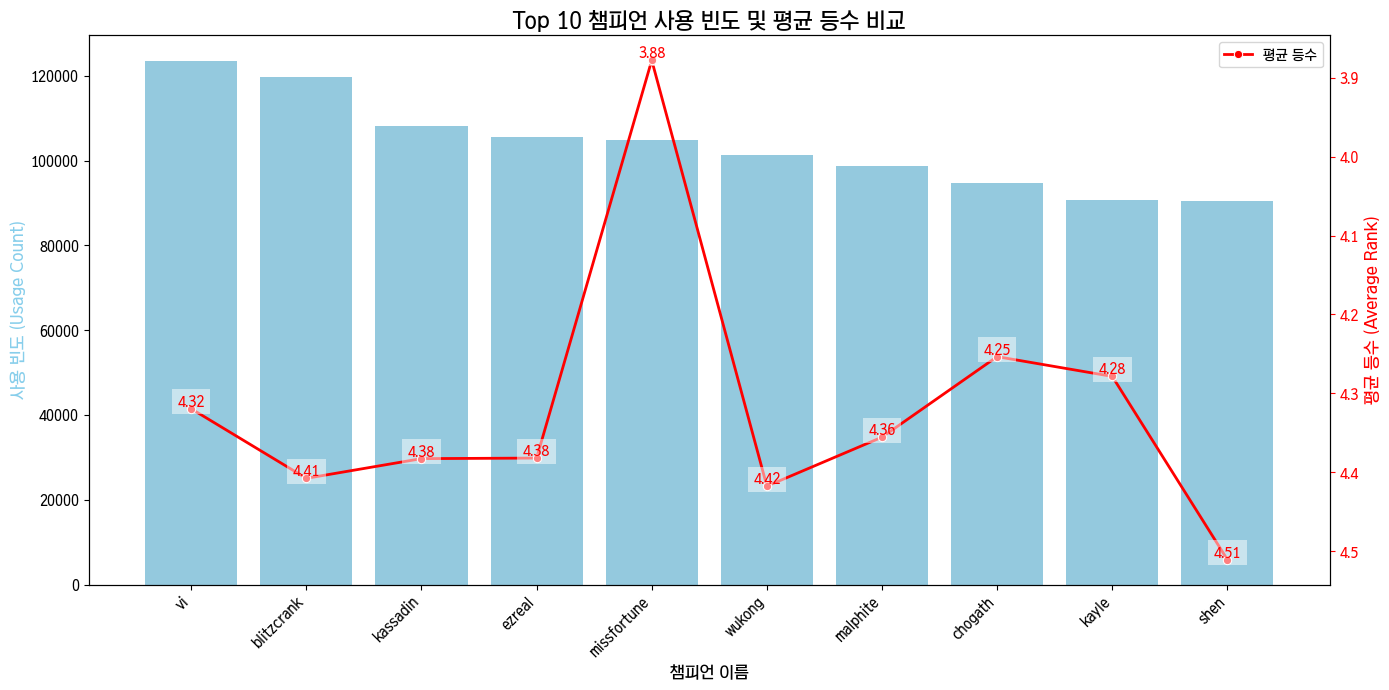

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14, 7))

# 1. 막대 그래프 (사용 빈도)
ax1 = sns.barplot(
    x='champion_name', 
    y='usage_count', 
    data=df_top10_by_usage, 
    color='skyblue'
)

plt.title('Top 10 챔피언 사용 빈도 및 평균 등수 비교', fontsize=16)
ax1.set_xlabel('챔피언 이름', fontsize=12)
ax1.set_ylabel('사용 빈도 (Usage Count)', fontsize=12, color='skyblue')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# 2. 이중 축 설정 (평균 등수)
ax2 = ax1.twinx()
sns.lineplot(
    x='champion_name', 
    y='average_rank', 
    data=df_top10_by_usage, 
    ax=ax2, 
    color='red', 
    marker='o', 
    linewidth=2,
    label='평균 등수'
)

# 3. 평균 등수 축 설정
ax2.set_ylabel('평균 등수 (Average Rank)', fontsize=12, color='red')
ax2.invert_yaxis() # 등수는 낮을수록 좋으므로 역순 설정
ax2.tick_params(axis='y', colors='red')

# 4. 데이터 값 레이블 추가 (평균 등수)
for i, row in df_top10_by_usage.iterrows():
    ax2.text(
        i, 
        row['average_rank'], 
        f"{row['average_rank']:.2f}", 
        color='red', 
        ha="center", 
        va="bottom",
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )

ax2.grid(False) 
plt.tight_layout()
plt.show()

In [23]:
'''
Top 10 챔피언 분석
1. 사용 빈도 (막대 그래프, 왼쪽 축)
Vi와 Blitzcrank가 가장 많이 사용된 챔피언이나 그 차이가 심하진 않음 (각각 약 123,360회, 119,664회 사용)

2. 평균 등수 (선 그래프, 오른쪽 축)
Miss Fortune이 Top 10 챔피언 중가장 좋은 평균 등수(3.88)를 기록
이는 유저들이 Miss Fortune을 많이 사용했을 뿐만 아니라, 승률도 높다는 것을 의미

'''

'\nTop 10 챔피언 분석\n1. 사용 빈도 (막대 그래프, 왼쪽 축)\nVi와 Blitzcrank가 가장 많이 사용된 챔피언이나 그 차이가 심하진 않음 (각각 약 123,360회, 119,664회 사용)\n\n2. 평균 등수 (선 그래프, 오른쪽 축)\nMiss Fortune이 Top 10 챔피언 중가장 좋은 평균 등수(3.88)를 기록\n이는 유저들이 Miss Fortune을 많이 사용했을 뿐만 아니라, 승률도 높다는 것을 의미\n\n'

In [ ]:
'''
#### 

- 이상치4 제거 - total_cost IQR
    [Q1 (25%): 19.00, Q3 (75%): 26.00
    IQR: 7.00
    계산된 제거 기준: 8.50 ~ 36.50
    제거된 행 수: 6581개
    최종 데이터 행 수: 393070개]

- 챔피언 별 사용 빈도와 평균 등수 시각화

#### - 추가 분석

1. 평균 등수가 높은 Miss Fortune의 시너지 조합 분석

2.초반에 판가름나는 조합 분석
12~30(하위25%)라운드에 탈락자(5~8위)가 발생한 게임만을 추출하여, 해당 게임에서 승리한 상위 1~4위의 조합을 분석해 초반 스노우볼링에 강한 조합
'''